In [86]:
import pandas as pd
import os
from random import choices
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score
from tqdm.notebook import tqdm
from src.utils import download_table, get_wandb_summaries
from src.data.utils import load_json, download_wandb_table
import wandb
from pprint import pprint
import matplotlib.pyplot as plt
import json
import re
import seaborn as sns
import collections
import glob 
import itertools
import matplotlib.patches as mpatches
from src.data.hierarchical_bootstrapping import hierarchical_bootstrapping
sns.color_palette

colors = sns.color_palette().as_hex()
print(colors)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [87]:
api = wandb.Api()

def search_experiments(model="CNNToTransformerClassifier", task="PredictFluPos", notes="hourly temporal split", tags="pretrained", _n_runs=5):
    """
    returns experiments ids that match a given a model name, task, and notes. Should return one entry per run (i.e. 5)
    """
    
    filters={"summary_metrics.model": model, "summary_metrics.task": task, "notes": notes}
    
    if tags is not None:
        if isinstance(tags, dict) and "not" in tags:
            tags = {"$not": tags["not"]}
        filters["tags"] = tags
    
    query = api.runs(
            path="bdata/ICML-2023-Flu-Dataset",
            filters=filters,
            order="+summary_metrics.pl_seed"
    )

    return query

In [88]:
def get_prediction_tables(run_ids, entities=["mikeamerrill","safranchik"], projects=["ICML-2023-Flu-Dataset", "mobs"], no_mobs=False):
    if no_mobs:
        projects = ["ICML-2023-Flu-Dataset"]
    tables = []
    for run_id in run_ids:
        for entity in entities:
            for project in projects:
                # TODO: pull runs from the bdata/Homekit project 
                try:
                    tables.append(download_wandb_table(run_id.id, table_name="test_predictions", entity=entity, project=project))
                except:
                    continue
    return tables

In [89]:
import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
            

In [90]:
fig = plt.gcf()

fig.set_size_inches(30, 20)

METRICS = [roc_auc_score, average_precision_score]
METRICS_NAMES = ["AUROC", "PR-AUC"]

# format: model name, notes, label, color
MODELS = [
            ("XGBoostClassifier", "daily temporal split", None, {"label": "XGBoost (day)", "color": colors[5], "marker": 'd'},6),
            ("XGBoostClassifier", "daily user split", None, {"label": "XGBoost (day)", "color": colors[5], "marker": 'd'},6),
            
            ("XGBoostClassifier", "hourly temporal split", None, {"label": "XGBoost (hour)", "color": colors[5], "marker": 'o'}, 5),
            ("XGBoostClassifier", "hourly user split", None, {"label": "XGBoost (hour)", "color": colors[5], "marker": 'o'}, 5),
            
            ("CNNClassifier", "temporal split", None, {"label": "CNN", "color": colors[1], "marker": "s"}, 1),
            ("CNNClassifier", "user split", None, {"label": "CNN", "color": colors[1], "marker": "s"}, 1),
            
            ("CNNClassifier", "hourly temporal split", None, {"label": "CNN (hour)", "color": colors[2], "marker": "o"}, 2),
            ("CNNClassifier", "hourly user split", None, {"label": "CNN (hour)", "color": colors[2], "marker": "o"}, 2),
            
            ("TransformerClassifier", "hourly temporal split", None, {"label": "Transformer (hour)", "color": colors[3], "marker": "o"}, 3),
            ("TransformerClassifier", "hourly user split", None, {"label": "Transformer (hour)", "color": colors[3], "marker": "o"}, 3),
    
            ("CNNToTransformerClassifier", "temporal split", {"not": "pretrained"}, {"label": "CNN-Transformer", "color": colors[0], "marker":'s'}, 0),
            ("CNNToTransformerClassifier", "user split", {"not": "pretrained"}, {"label": "CNN-Transformer", "color": colors[0], "marker":'s'}, 0),  

            ("ResNet", "temporal split", None, {"label": "ResNet", "color": colors[6], "marker": "o"}, 4),
            ("ResNet", "user split", None, {"label": "ResNet", "color": colors[6], "marker": "o"}, 4),        
            
            ("ResNet", "hourly temporal split", None, {"label": "ResNet (hour)", "color": colors[6], "marker": "o"}, 4),
            ("ResNet", "hourly user split", None, {"label": "ResNet (hour)", "color": colors[6], "marker": "o"}, 4),  
    
 
            ("InceptionTime", "user split", None, {"label": "InceptionTime", "color": colors[6], "marker": "o"}, 7),
            ("InceptionTime", "temporal split", None, {"label": "InceptionTime", "color": colors[6], "marker": "o"}, 7)
        ]            


TASKS = ["HomekitPredictFluPos", "HomekitPredictSevereFever", "HomekitPredictCough", "HomekitPredictFatigue",  "HomekitPredictFluSymptoms"]
TASK_NAMES = ["Flu Positivity\n1:2,760",  "Severe Fever\n1:643", "Severe Cough\n1:132", "Severe Fatigue\n1:78",  "Flu Symptoms\n1:37"]
TAKS_NAME_MAP=dict(zip(TASKS, TASK_NAMES))
NUM_BOOTSTRAPS=10

MODEL_ORDER=[]
for m in MODELS:
    if not m[3]["label"] in MODEL_ORDER:
        MODEL_ORDER.append(m[3]["label"])

assert len(TASKS) == len(TASK_NAMES)

splits = ["user", "temporal"]


<Figure size 3000x2000 with 0 Axes>

In [91]:
metric_results = []
metric_results_with_tables = []

""" fills out the nested data dictionary """
for t, task in enumerate(TASKS):
    for k, (model, note, tags, kwargs, order) in enumerate(MODELS):
        
        model_name = kwargs["label"]
        s = "temporal" if "temporal" in note else "user"
        
        run_ids = search_experiments(model, task, note, tags)
        tables = get_prediction_tables(run_ids, no_mobs=(model=="CNNToTransformerClassifier"))
        
        if not isinstance(tables, list):
            continue
            
        if len(tables) != 5:
            print("{}-{} with note \"{}\" and tags \"{}\" has length {}".format(model, task, note, tags, len(tables)))

            continue

        assert len(tables) == 5
                    
        # 40 model bootstraps lets us discard the bottom and top outliers to obtain a 95% CI
        bootstraps = hierarchical_bootstrapping(tables, num_bootstraps=NUM_BOOTSTRAPS, metrics=METRICS)
            
        for m, metric in enumerate(METRICS):

            bootstraps_list = bootstraps[metric.__name__]
            metric_mean = np.mean(bootstraps_list)
            metric_err = np.abs(np.percentile(bootstraps_list, (0.975, 0.025)) - metric_mean)
            metric_results.append({"model_name": model_name, "task": task,  "metric": metric.__name__, 
                                   "mean": metric_mean, "err": metric_err, "split":s})
            metric_results_with_tables.append({"model_name": model_name, "task": task,  "metric": metric.__name__,
                                                  "mean": metric_mean, "err": metric_err, "split":s, "tables": tables})
    

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

In [92]:
def precision_at_k(y_true, y_pred, k=10):
    if isinstance(k,float):
        k = int(k*len(y_true))
    y_pred = y_pred.argsort()[-k:][::-1]
    return np.mean(y_true[y_pred])


p_at_ks = []
task_ks = []
ks = [0.0005,0.001,0.005,0.01,0.1]
task_labels = {}

for result in metric_results_with_tables:
    tables = result["tables"]
    metric = result["metric"]
    task = result["task"]
    split = result["split"]
    
    if not metric == "roc_auc_score": # Only do this once per task per split per model
        continue

    for k in ks:

        task_ks.append({"task":task, "k":k, "n": int(k * len(tables[0]["label"]))})
        mean = np.mean([precision_at_k(tables[i]["label"], tables[i]["pred"],k=k) for i in range(5)])
        p_at_ks.append({"model_name": result["model_name"], "task": task,  "metric": f"p_at_{k}", "split":split, "mean": mean, "k" : k})
        task_labels[(TAKS_NAME_MAP[task],{"temporal":"Temporal","user":"User"}[split])] = tables[0]["label"].values
     
        
p_at_ks = pd.DataFrame(p_at_ks)
p_at_ks["task"] = p_at_ks["task"].map(TAKS_NAME_MAP)
p_at_ks["split"] = p_at_ks["split"].map({"temporal":"Temporal","user":"User"})

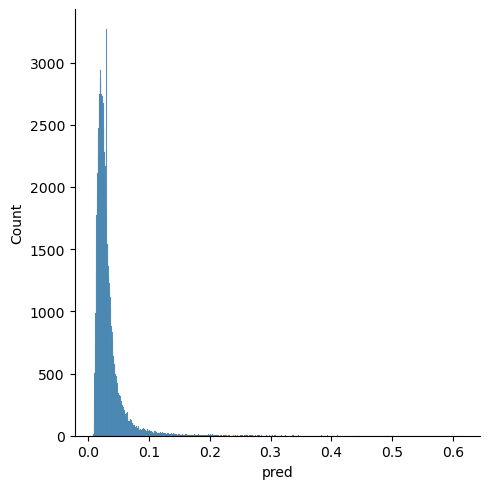

In [93]:
sns.displot(tables[0]["pred"])

In [94]:
MODEL_ORDER.index("InceptionTime")
p_at_ks["model_order"] = p_at_ks["model_name"].map(MODEL_ORDER.index)
p_at_ks = p_at_ks.sort_values(["model_order","k"])

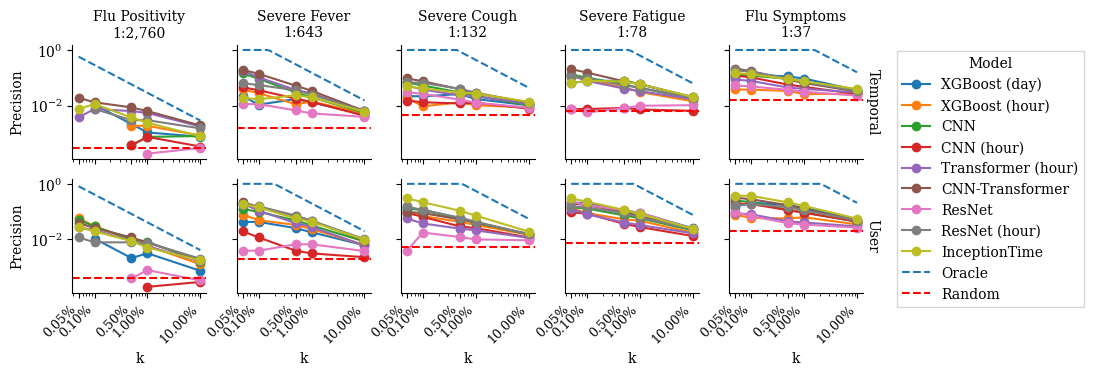

In [127]:
def logplot(x,y,**kwargs):
    plt.plot(x,y,**kwargs)
    ax = plt.gca()
    ax.set_xscale("log")
    ax.set_yscale("log")


with plt.style.context('../../src/visualization/stylesheets/paper.mplstyle'):   

    
    
    
    grid = sns.FacetGrid(p_at_ks[p_at_ks["mean"]!=0], col="task", hue="model_name", row="split", 
                        height=1.8, aspect=1, margin_titles=True, col_order = TASK_NAMES,
                        legend_out=True,sharey=True, palette="tab10")

    # Draw a horizontal line to show the starting point
    # grid.refline(y=0, linestyle=":")
    # Draw a line plot to show the trajectory of each random walk
#     p_at_ks["mean_"] = p_at_ks["mean"] + 0.001
    grid.map(logplot, "k", "mean", marker="o")

    grid.set_titles(col_template="{col_name}", row_template="{row_name}")
    grid.set_axis_labels("k", "Precision")

    # # Adjust the tick positions and labels

    x_labels = ["{0:.2%}".format(i) for i in ks]
    grid.set(xticks=ks, xticklabels=x_labels)
#     grid.set(xscale="log")
    ## Rorate the x labels and make them smaller:
    for ax in grid.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_fontsize(9)
            label.set_horizontalalignment('right')
#         ax.title.set_fontsize(8)

    ##Make subplot titles smaller

    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    # Adjust the arrangement of the plots
    # grid.fig.tight_layout(w_pad=1)
    
    # Such a hack...
    plot_keys = [(y,x) for x in ["Temporal", "User"] for y in TASK_NAMES]
    for (split,task), (i,ax) in zip(plot_keys, enumerate(grid.axes.flatten())):
        labels = task_labels[(split,task)]
        n = len(labels)
        n_pos = sum(labels)
        x = np.exp(np.linspace(np.log(0.0005),np.log(0.1)))
        s = n * x # sample sizes at threshold
        y = [min(1.0, n_pos/ss) for ss in s]
        plt.sca(ax)
        plt.plot(x,y,linestyle="dashed", label="Oracle")
        
        # Plotting prevelance 
        plt.axhline(n_pos/n,linestyle="dashed",c="r", label="Random")
#         print(i, n_pos/n)
#     grid.add_legend(title="Model", fancybox=True)

    plt.legend(title="Model",loc='center left', bbox_to_anchor=(1.2, 1.0), fancybox=False)
#     plt.tight_layout()
    plt.savefig("../../reports/CHIL2023/p_at_k.pdf", bbox_inches="tight")

In [112]:
p_at_ks[(p_at_ks["task"] == 'Flu Positivity\n1:2,760')  & (p_at_ks["model_name"] == "CNN-Transformer")]

,model_name,task,metric,split,mean,k,model_order
50,CNN-Transformer,"Flu Positivity\n1:2,760",p_at_0.0005,Temporal,0.018868,0.0005,5
55,CNN-Transformer,"Flu Positivity\n1:2,760",p_at_0.0005,User,0.039216,0.0005,5
51,CNN-Transformer,"Flu Positivity\n1:2,760",p_at_0.001,Temporal,0.013084,0.0010,5
56,CNN-Transformer,"Flu Positivity\n1:2,760",p_at_0.001,User,0.025490,0.0010,5
52,CNN-Transformer,"Flu Positivity\n1:2,760",p_at_0.005,Temporal,0.008534,0.0050,5
57,CNN-Transformer,"Flu Positivity\n1:2,760",p_at_0.005,User,0.011742,0.0050,5
53,CNN-Transformer,"Flu Positivity\n1:2,760",p_at_0.01,Temporal,0.006302,0.0100,5
58,CNN-Transformer,"Flu Positivity\n1:2,760",p_at_0.01,User,0.007632,0.0100,5
54,CNN-Transformer,"Flu Positivity\n1:2,760",p_at_0.1,Temporal,0.001909,0.1000,5
59,CNN-Transformer,"Flu Positivity\n1:2,760",p_at_0.1,User,0.001878,0.1000,5


In [111]:
p_at_ks["task"].unique()

array(['Flu Positivity\n1:2,760', 'Severe Fever\n1:643',
       'Severe Cough\n1:132', 'Severe Fatigue\n1:78',
       'Flu Symptoms\n1:37'], dtype=object)

In [96]:
## Making New Tables
metric_df = pd.DataFrame(metric_results)
metric_df["task"] = metric_df["task"].map(TAKS_NAME_MAP)
metric_df["split"] = metric_df["split"].map({"temporal":"Temp.","user":"User"})
metric_df = metric_df.pivot(values=["mean"], index=["model_name","metric"], columns=["task","split"])
metric_df.head()

mean            \
task                                    Flu Positivity\n1:2,760             
split                                                     Temp.      User   
model_name      metric                                                      
CNN             average_precision_score                0.000777  0.012597   
                roc_auc_score                          0.715742  0.732003   
CNN (hour)      average_precision_score                0.000319  0.000469   
                roc_auc_score                          0.497290  0.479684   
CNN-Transformer average_precision_score                0.012202  0.012802   

                                                                       \
task                                    Severe Fever\n1:643             
split                                                 Temp.      User   
model_name      metric                                                  
CNN             average_precision_score            0.027407  0.027434   
                roc_auc_score                      0.714539  0.717498   
CNN (hour)      average_precision_score            0.009633  0.002706   
                roc_auc_score                      0.648232  0.534276   
CNN-Transformer average_precision_score            0.045807  0.047219   

                                                                       \
task                                    Severe Cough\n1:132             
split                                                 Temp.      User   
model_name      metric                                                  
CNN             average_precision_score            0.011892  0.020912   
                roc_auc_score                      0.646711  0.663184   
CNN (hour)      average_precision_score            0.007069  0.012133   
                roc_auc_score                      0.590003  0.603856   
CNN-Transformer average_precision_score            0.014596  0.019296   

                                                                        \
task                                    Severe Fatigue\n1:78             
split                                                  Temp.      User   
model_name      metric                                                   
CNN             average_precision_score             0.022642  0.024012   
                roc_auc_score                       0.677396  0.655219   
CNN (hour)      average_precision_score             0.006280  0.014029   
                roc_auc_score                       0.500886  0.576128   
CNN-Transformer average_precision_score             0.030378  0.035102   

                                                                      
task                                    Flu Symptoms\n1:37            
split                                                Temp.      User  
model_name      metric                                                
CNN             average_precision_score           0.030511  0.039679  
                roc_auc_score                     0.612898  0.602908  
CNN (hour)      average_precision_score           0.023433  0.038658  
                roc_auc_score                     0.563039  0.602793  
CNN-Transformer average_precision_score           0.032350  0.048786

In [97]:
rocs = metric_df.xs("roc_auc_score",level=1).reindex(MODEL_ORDER)
prs = metric_df.xs("average_precision_score",level=1).reindex(MODEL_ORDER)

In [98]:
def highlight_max_latex(s):
    is_max = s == s.max()
    return ['bfseries: ' if cell else '' for cell in is_max]
  
print(rocs.style.apply(highlight_max_latex).format(precision=3)\
                .to_latex(hrules=True, multicol_align="c",))

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & \multicolumn{10}{c}{mean} \\
task & \multicolumn{2}{c}{Flu Positivity
1:2,760} & \multicolumn{2}{c}{Severe Fever
1:643} & \multicolumn{2}{c}{Severe Cough
1:132} & \multicolumn{2}{c}{Severe Fatigue
1:78} & \multicolumn{2}{c}{Flu Symptoms
1:37} \\
split & Temp. & User & Temp. & User & Temp. & User & Temp. & User & Temp. & User \\
model_name &  &  &  &  &  &  &  &  &  &  \\
\midrule
XGBoost (day) & 0.566 & 0.561 & 0.638 & 0.686 & 0.667 & 0.656 & 0.693 & \bfseries 0.709 & 0.616 & \bfseries 0.652 \\
XGBoost (hour) & 0.683 & 0.679 & 0.680 & 0.670 & 0.640 & 0.677 & 0.652 & 0.639 & 0.599 & 0.596 \\
CNN & 0.716 & 0.732 & 0.715 & 0.717 & 0.647 & 0.663 & 0.677 & 0.655 & 0.613 & 0.603 \\
CNN (hour) & 0.497 & 0.480 & 0.648 & 0.534 & 0.590 & 0.604 & 0.501 & 0.576 & 0.563 & 0.603 \\
Transformer (hour) & 0.856 & 0.761 & 0.721 & 0.731 & 0.662 & 0.666 & 0.659 & 0.654 & 0.588 & 0.593 \\
CNN-Transformer & \bfseries 0.876 & 0.795 & 0.737 & 0.734 & 0.669 & 0.646 & 0.

In [99]:
print(prs.style.apply(highlight_max_latex).format(precision=3)\
                .to_latex(hrules=True, multicol_align="c",))

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & \multicolumn{10}{c}{mean} \\
task & \multicolumn{2}{c}{Flu Positivity
1:2,760} & \multicolumn{2}{c}{Severe Fever
1:643} & \multicolumn{2}{c}{Severe Cough
1:132} & \multicolumn{2}{c}{Severe Fatigue
1:78} & \multicolumn{2}{c}{Flu Symptoms
1:37} \\
split & Temp. & User & Temp. & User & Temp. & User & Temp. & User & Temp. & User \\
model_name &  &  &  &  &  &  &  &  &  &  \\
\midrule
XGBoost (day) & 0.001 & 0.001 & 0.007 & 0.011 & 0.009 & 0.017 & 0.024 & 0.037 & 0.034 & 0.050 \\
XGBoost (hour) & 0.001 & \bfseries 0.019 & 0.007 & 0.009 & 0.007 & 0.017 & 0.016 & 0.020 & 0.022 & 0.030 \\
CNN & 0.001 & 0.013 & 0.027 & 0.027 & 0.012 & 0.021 & 0.023 & 0.024 & 0.031 & 0.040 \\
CNN (hour) & 0.000 & 0.000 & 0.010 & 0.003 & 0.007 & 0.012 & 0.006 & 0.014 & 0.023 & 0.039 \\
Transformer (hour) & 0.005 & 0.011 & 0.036 & \bfseries 0.057 & 0.010 & 0.013 & 0.019 & 0.019 & 0.024 & 0.025 \\
CNN-Transformer & \bfseries 0.012 & 0.013 & \bfseries 0.046 & 0.047 & 0.015 & 